### Deep Learning Model
Battery SOH Prediction
- 주요 코드 일부를 공개 버전으로 만들었습니다.
- DB에서 모델 학습을 위한 전처리 부분은 보안상 생략하였습니다.
- 사용자 정의 라이브러리는 별도의 파일로 존재합니다.

기본 라이브러리를 읽어 오고, DB를 불러 오는 함수를 정의합니다. (MySQL 사용)

In [ ]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotlyuser as pu
import kuserlib as k
import sqldblib as sq
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def db_load(ip='192.139.32.21') :
    
    # DB 서버에 접속하여 데이터를 읽어 옵니다.
       conn = pymysql.connect(host=ip, user='master', password='password', port=3306, db='db_name', local_infile=False)
 
       columns_name = ['deviceNo', 'messageTime', 'time', 'startTime', 'internalTemp',
              'externalTemp', 'soc', 'acceptableChargingPower',
              'acceptableDischargingPower', 'mainRelayConnected',
              'slowChargingPortConnected', 'fastChargingPortConnected', 'v2l',
              'packCurrent', 'packVoltage', 'moduleMaxTemp', 'moduleMinTemp',
              'moduleTempList', 'battInternalTemp', 'maxCellVoltage',
              'maxCellVoltageNo', 'minCellVoltage', 'minCellVoltageNo',
              'battFanRunning', 'subBattVoltage', 'cumulativeCurrentCharged',
              'cumulativeCurrentDischarged', 'cumulativePowerCharged',
              'cumulativePowerDischarged', 'operationTime', 'bmsRunning',
              'inverterCapacityVoltage', 'driveMotorSpd1', 'driveMotorSpd2',
              'insulatedResistance', 'cellVoltageList', 'cellVoltageDispersion',
              'airbagHWireDuty', 'hvacList1', 'hvacList2', 'soh',
              'maxDeteriorationCellNo', 'minDeterioratation',
              'minDeteriorationCellNo', 'socd', 'emobilitySpeed', 'moduleAvgTemp',
              'batteryPower', 'odometer', 'fastChargingRelayOn',
              'chargingCableConnected', 'estimatedChargingTime', 'tripChargingPower',
              'tripDischargingPower', 'battCoolantInletTemp', 'battPraBusbarTemp',
              'battLtrRearTemp', 'chargeCount', 'chargeCountQuick', 'umulEnergyChrgd',
              'cumulEnergyChrgdQuick']
       
       return conn, columns_name


In [ ]:
# SOH 계산 테이블 데이터 읽어오기

table_id = 'v3_cal_soh'

conn = db_load

df_soh = sq.read_table_all(conn, table_id)
df_soh

Table name :  v3_cal_soh


,upload_date,car_id,car_model,start_time,end_time,charge_minutes,model_year,end_cycle,start_soc,end_soc,delta_soc,end_odometer,end_cumPowDischared,end_soh,delta_Q,SOH_prediction,fitting
0,2024-12-17 09:59:51,01229994779,아이오닉5,2022-09-29 12:59:14,2022-09-29 15:44:05,164.8,0.58,46.8609,68.5,87.0,18.5,14058,3402.1,100.0,21.2,103.053,1.0
1,2024-12-17 09:59:51,01229994779,아이오닉5,2022-10-02 17:37:44,2022-10-02 19:57:58,140.2,0.59,47.8512,37.0,55.0,18.0,14373,3474.0,100.0,20.6,102.918,1.0
2,2024-12-17 09:59:51,01229994779,아이오닉5,2022-10-04 07:05:13,2022-10-04 14:16:15,431.0,0.60,48.1432,37.0,87.0,50.0,14462,3495.2,100.0,57.2,102.878,1.0
3,2024-12-17 09:59:51,01229994779,아이오닉5,2022-10-07 07:05:12,2022-10-07 13:37:28,392.3,0.60,48.9063,40.5,87.0,46.5,14699,3550.6,100.0,53.2,102.885,1.0
4,2024-12-17 10:00:38,01241124004,EV6,2022-10-09 17:16:17,2022-10-09 20:05:40,169.4,0.48,12.1253,77.0,96.5,19.5,4039,938.5,100.0,22.3,102.841,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137874,2025-07-28 00:16:03,01241248920,EV6,2025-07-26 19:18:20,2025-07-27 02:33:40,435.3,3.24,15.8488,44.0,96.5,52.5,80966,1226.7,99.6,60.1,102.946,1.0
137875,2025-07-28 00:16:24,01241248843,EV6,2025-07-26 16:13:55,2025-07-27 08:52:50,998.9,2.66,21.6486,55.5,95.0,39.5,62312,1675.6,100.0,45.2,102.905,1.0
137876,2025-07-28 00:16:32,01241597847,EV6,2025-07-26 20:01:40,2025-07-27 06:18:34,616.9,1.74,20.6202,13.5,88.5,75.0,51661,1596.0,100.0,85.8,102.878,1.0
137877,2025-07-28 00:16:33,01241592884,EV6,2025-07-27 18:02:10,2025-07-27 23:54:54,352.7,2.24,88.5853,41.5,80.5,39.0,90581,6856.5,100.0,44.6,102.841,1.0


In [6]:
model_name = 'EV6'

df_soh[df_soh['car_model'] == model_name]

,upload_date,car_id,car_model,start_time,end_time,charge_minutes,model_year,end_cycle,start_soc,end_soc,delta_soc,end_odometer,end_cumPowDischared,end_soh,delta_Q,SOH_prediction,fitting
4,2024-12-17 10:00:38,01241124004,EV6,2022-10-09 17:16:17,2022-10-09 20:05:40,169.4,0.48,12.12530,77.0,96.5,19.5,4039,938.5,100.0,22.3,102.841,1.0
19,2024-12-17 10:00:26,01241123951,EV6,2022-10-27 10:14:34,2022-10-28 10:24:49,1450.2,0.41,8.41602,73.5,96.0,22.5,2724,651.4,100.0,25.6,102.318,1.0
21,2024-12-17 10:00:38,01241124004,EV6,2022-10-28 23:05:12,2022-10-29 03:37:45,272.6,0.53,13.53620,64.0,96.5,32.5,4434,1047.7,100.0,37.2,102.933,1.0
29,2024-12-17 10:00:26,01241123951,EV6,2022-11-05 05:52:54,2022-11-06 14:42:05,1969.2,0.43,9.04134,63.5,96.0,32.5,2881,699.8,100.0,33.2,91.865,0.0
36,2024-12-17 10:00:38,01241124004,EV6,2022-11-16 20:55:33,2022-11-17 01:03:52,248.3,0.58,14.14730,67.0,96.5,29.5,4651,1095.0,100.0,33.8,103.036,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137872,2025-07-28 00:15:58,01241597735,EV6,2025-07-27 19:38:46,2025-07-27 22:35:37,176.8,1.99,8.37468,57.0,78.0,21.0,14561,648.2,100.0,24.1,103.203,1.0
137874,2025-07-28 00:16:03,01241248920,EV6,2025-07-26 19:18:20,2025-07-27 02:33:40,435.3,3.24,15.84880,44.0,96.5,52.5,80966,1226.7,99.6,60.1,102.946,1.0
137875,2025-07-28 00:16:24,01241248843,EV6,2025-07-26 16:13:55,2025-07-27 08:52:50,998.9,2.66,21.64860,55.5,95.0,39.5,62312,1675.6,100.0,45.2,102.905,1.0
137876,2025-07-28 00:16:32,01241597847,EV6,2025-07-26 20:01:40,2025-07-27 06:18:34,616.9,1.74,20.62020,13.5,88.5,75.0,51661,1596.0,100.0,85.8,102.878,1.0


In [8]:
car_id_list = list(df_soh[df_soh['car_model'] == model_name]['car_id'].unique())   # 차량 ID
car_id_list

['01241124004',
 '01241123951',
 '01241228107',
 '01241228104',
 '01241228095',
 '01241228099',
 '01241228091',
 '01241228103',
 '01241228132',
 '01241228087',
 '01241228057',
 '01241228051',
 '01241228088',
 '01241228059',
 '01241228049',
 '01241228090',
 '01241228086',
 '01241228061',
 '01241228073',
 '01241228092',
 '01241248930',
 '01241228128',
 '01241248908',
 '01241248913',
 '01241248860',
 '01241248925',
 '01241248922',
 '01241248850',
 '01241228085',
 '01241248877',
 '01241228075',
 '01241248831',
 '01241248892',
 '01241248891',
 '01241228082',
 '01241248904',
 '01241248842',
 '01241248833',
 '01241248876',
 '01241248843',
 '01241228098',
 '01241248933',
 '01241248921',
 '01241248878',
 '01241248909',
 '01241248934',
 '01241248845',
 '01241228055',
 '01241248927',
 '01241321947',
 '01241321946',
 '01241321944',
 '01241248919',
 '01241321940',
 '01241321942',
 '01241321948',
 '01241321939',
 '01241248928',
 '01241248901',
 '01241321943',
 '01241321941',
 '01241321938',
 '012412

In [9]:
len(car_id_list)

257

### Raw Data 읽어 오기

In [10]:
# 해당 차량의 SOH 결과 테이블 읽기

table_id = '01241597766'    # EV6 제이카 : 01241597766

dataset_soh = df_soh[df_soh['car_id'] == table_id].reset_index(drop=True)
dataset_soh

,upload_date,car_id,car_model,start_time,end_time,charge_minutes,model_year,end_cycle,start_soc,end_soc,delta_soc,end_odometer,end_cumPowDischared,end_soh,delta_Q,SOH_prediction,fitting
0,2024-12-17 14:12:35,01241597766,EV6,2023-10-27 16:33:42,2023-10-27 17:04:42,31.0,2.16,20.14080,64.5,90.0,25.5,29899,1558.9,100.0,29.2,102.976,1.0
1,2024-12-17 14:12:35,01241597766,EV6,2023-10-28 15:18:36,2023-10-28 16:30:25,71.8,2.16,20.79460,53.0,96.5,43.5,30119,1609.5,100.0,49.8,102.952,1.0
2,2024-12-17 14:12:35,01241597766,EV6,2023-11-03 20:48:41,2023-11-04 03:38:09,409.5,2.18,21.72870,38.0,87.0,49.0,30474,1681.8,100.0,56.1,102.958,1.0
3,2024-12-17 14:12:35,01241597766,EV6,2023-11-17 19:37:35,2023-11-18 01:22:00,344.4,2.21,22.58530,37.5,78.0,40.5,30765,1748.1,100.0,46.3,102.807,1.0
4,2024-12-17 14:12:35,01241597766,EV6,2023-11-26 21:40:30,2023-11-27 06:08:44,508.2,2.24,23.21320,36.0,96.0,60.0,30990,1796.7,100.0,68.7,102.968,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2025-03-03 00:16:30,01241597766,EV6,2025-03-01 17:57:26,2025-03-02 01:39:46,462.3,3.50,8.03230,21.5,78.5,57.0,43309,621.7,100.0,65.2,102.865,1.0
68,2025-03-09 00:16:41,01241597766,EV6,2025-03-08 11:31:13,2025-03-08 14:44:53,193.7,3.52,8.34496,55.0,78.5,23.5,43410,645.9,100.0,26.8,102.556,1.0
69,2025-03-11 00:16:23,01241597766,EV6,2025-03-09 19:54:48,2025-03-10 01:10:22,315.6,3.52,8.94961,41.5,78.0,36.5,43593,692.7,100.0,41.7,102.740,1.0
70,2025-03-25 00:16:16,01241597766,EV6,2025-03-22 14:37:11,2025-03-22 20:48:15,371.1,3.56,9.84238,24.5,71.0,46.5,43918,761.8,100.0,53.2,102.885,1.0


- SOH 결과는 각 충전 구간의 SOC 데이터를 읽어와 전류적산법(Coulomb Counting)을 이용해 계산된 값입니다. 
- 측정 Sensor의 오차가 존재하기 때문에 변동성을 확인할 수 있습니다.

Name :  SOH_prediction
Total Qty :  72
Avg :  102.895375
Min :  102.191
Max :  103.631
Range :  1.4399999999999977
Std :  0.20048465485165162


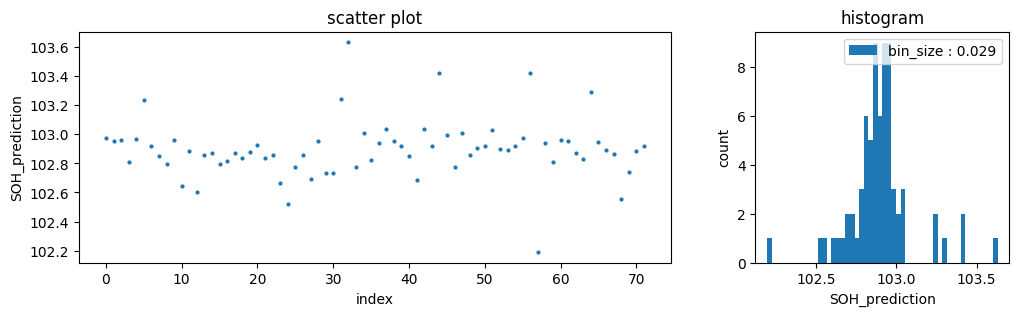

In [11]:
# SOH 결과 시각화

k.plot_feature(dataset_soh, 'SOH_prediction')

- 차량의 SOC 데이터를 통해 충전 및 방전 추이를 확인할 수 있습니다.

Name :  end_soc
Total Qty :  72
Avg :  77.35416666666667
Min :  24.5
Max :  96.5
Range :  72.0
Std :  16.531539957919275


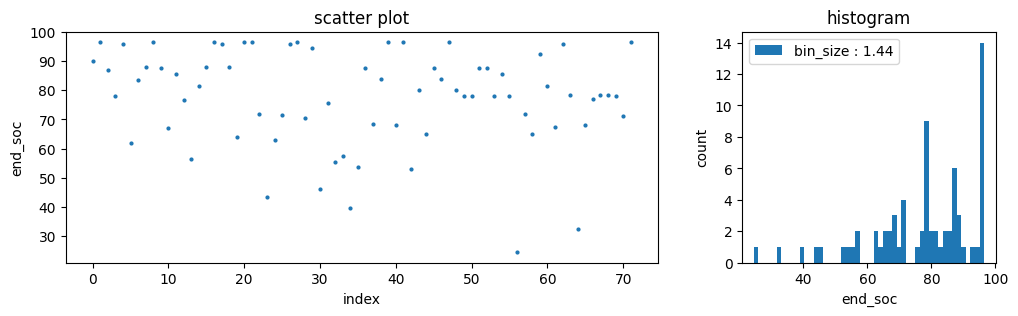

In [12]:
# end SOC 결과 시각화

k.plot_feature(dataset_soh, 'end_soc')

In [ ]:
# 차량 raw data 읽어오기

df = sq.read_table_all(conn, table_id)
df

01241597766
Table name :  01241597766


,deviceNo,messageTime,time,startTime,internalTemp,externalTemp,soc,acceptableChargingPower,acceptableDischargingPower,mainRelayConnected,...,estimatedChargingTime,tripChargingPower,tripDischargingPower,battCoolantInletTemp,battPraBusbarTemp,battLtrRearTemp,chargeCount,chargeCountQuick,cumulEnergyChrgd,cumulEnergyChrgdQuick
0,01241597766,2023-10-24 20:21:25,23-10-24 20:20:27,2023-10-24 20:20:25,24,18,90.5,167.9,277.0,0,...,0,0.0,0.0,22,28,24,25,12,905,141
1,01241597766,2023-10-24 20:21:25,23-10-24 20:20:29,2023-10-24 20:20:25,24,18,90.5,167.9,277.0,1,...,0,0.0,0.0,22,28,24,25,12,905,141
2,01241597766,2023-10-24 20:21:25,23-10-24 20:20:31,2023-10-24 20:20:25,24,18,90.5,167.9,277.0,1,...,0,0.0,0.0,22,28,24,25,12,905,141
3,01241597766,2023-10-24 20:21:25,23-10-24 20:20:33,2023-10-24 20:20:25,24,18,90.5,167.9,277.0,0,...,0,0.0,0.0,22,28,24,25,12,905,141
4,01241597766,2023-10-24 20:21:25,23-10-24 20:20:35,2023-10-24 20:20:25,24,18,90.5,167.9,277.0,1,...,0,0.0,0.0,22,28,24,25,12,905,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707694,01241597766,2025-07-17 11:17:30,25-07-17 11:17:21,2025-07-17 11:17:09,22,19,33.5,277.0,249.3,1,...,0,0.0,0.0,22,30,26,2,44,83,428
1707695,01241597766,2025-07-17 11:17:30,25-07-17 11:17:23,2025-07-17 11:17:09,22,19,33.5,277.0,249.3,0,...,0,0.0,0.0,22,30,26,2,44,83,428
1707696,01241597766,2025-07-17 11:17:30,25-07-17 11:17:25,2025-07-17 11:17:09,22,19,33.5,277.0,249.3,1,...,0,0.0,0.0,22,30,26,2,44,83,428
1707697,01241597766,2025-07-17 11:17:30,25-07-17 11:17:27,2025-07-17 11:17:09,22,19,33.5,277.0,249.3,1,...,0,0.0,0.0,22,30,26,2,44,83,428


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707699 entries, 0 to 1707698
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   deviceNo                     object 
 1   messageTime                  object 
 2   time                         object 
 3   startTime                    object 
 4   internalTemp                 int64  
 5   externalTemp                 int64  
 6   soc                          float64
 7   acceptableChargingPower      float64
 8   acceptableDischargingPower   float64
 9   mainRelayConnected           int64  
 10  slowChargingPortConnected    int64  
 11  fastChargingPortConnected    int64  
 12  v2l                          int64  
 13  packCurrent                  float64
 14  packVoltage                  float64
 15  moduleMaxTemp                float64
 16  moduleMinTemp                float64
 17  moduleTempList               object 
 18  battInternalTemp             float64
 19  

- 아래의 경우는 누적충전량이 이상치 발견된 사례입니다. 이러한 데이터는 전처리가 필요합니다.

Name :  cumulativeCurrentCharged
Total Qty :  1707699
Avg :  2977.7286722074577
Min :  0.0
Max :  5761.3
Range :  5761.3
Std :  1691.95681903346


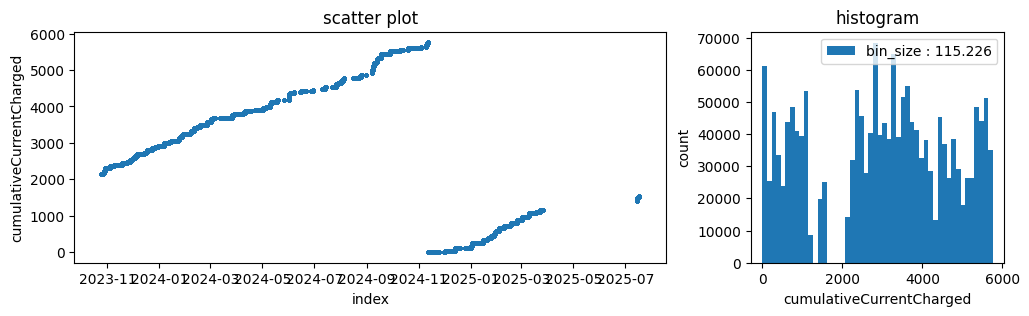

In [17]:
k.plot_feature(df,'cumulativeCurrentCharged')

- 누적방전량에서도 동일하게 이상치가 확인됩니다.

Name :  cumulativeCurrentDischarged
Total Qty :  1707699
Avg :  2895.5621670446603
Min :  0.0
Max :  5502.5
Range :  5502.5
Std :  1628.780806989871


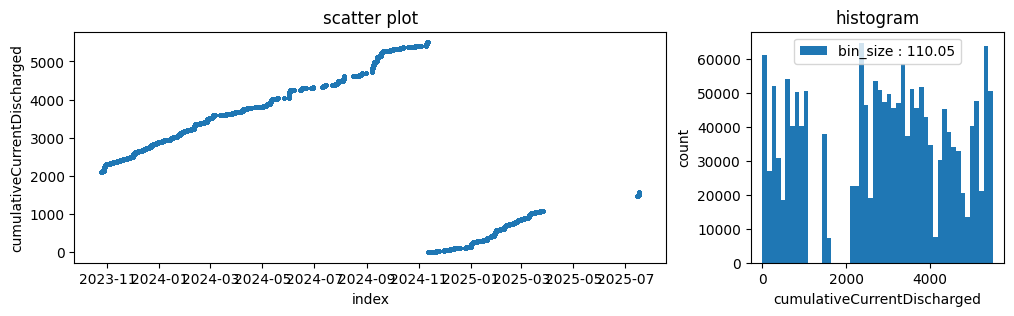

In [18]:
k.plot_feature(df,'cumulativeCurrentDischarged')

- 셀간 전압 편차가 발생하는지 확인합니다. 안전 진단을 위한 필수 요소입니다.

Name :  cellVoltageDispersion
Total Qty :  1707699
Avg :  0.00016506421799157816
Min :  0.0
Max :  0.06
Range :  0.06
Std :  0.0018717876122521207


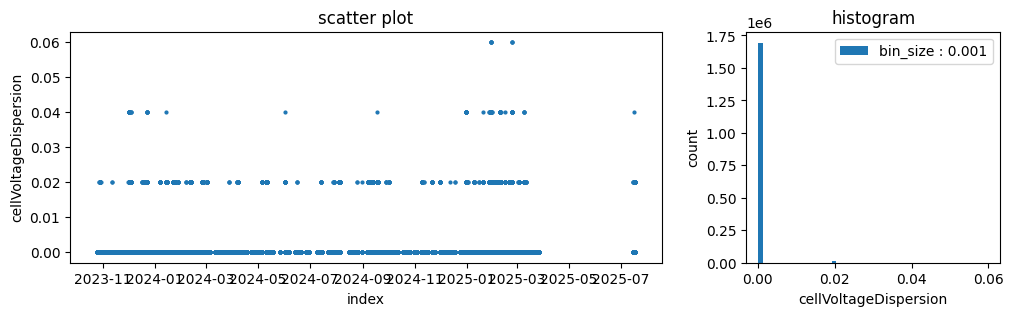

In [21]:
k.plot_feature(df,'cellVoltageDispersion')

- 특정 충전 구간의 전압, 전류, 온도 프로파일을 확인합니다.

Name :  packVoltage
Total Qty :  20493
Avg :  726.9606548577563
Min :  650.1
Max :  795.9
Range :  145.79999999999995
Std :  39.863976304101314


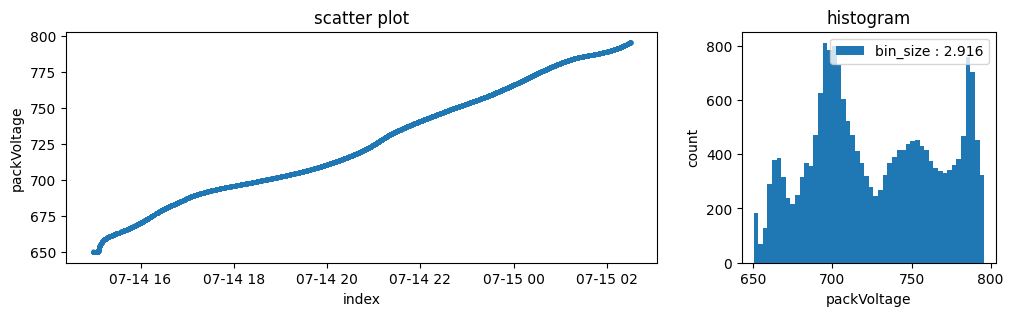

In [25]:
k.plot_feature(select_df,'packVoltage')

Name :  packCurrent
Total Qty :  20493
Avg :  -8.72574098472649
Min :  -9.7
Max :  2.8
Range :  12.5
Std :  1.1061416278471223


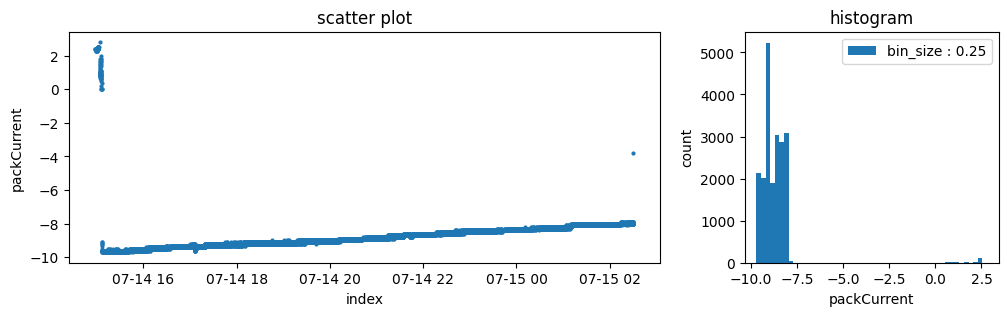

In [26]:
k.plot_feature(select_df,'packCurrent')

Name :  soc
Total Qty :  20493
Avg :  52.08066168935734
Min :  6.0
Max :  97.0
Range :  91.0
Std :  26.342440540690884


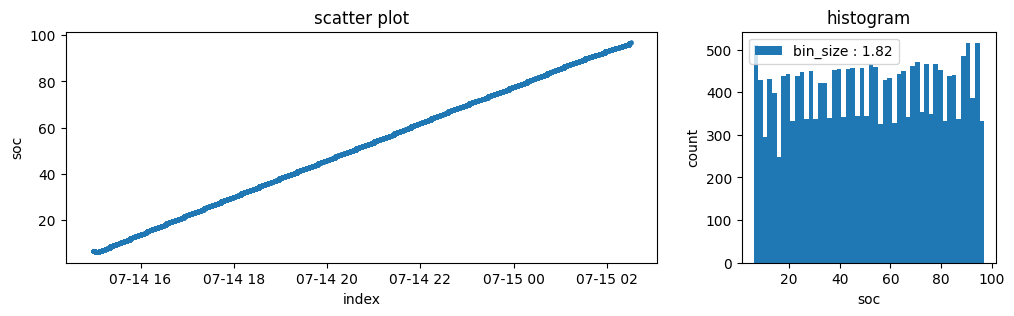

In [27]:
k.plot_feature(select_df,'soc')

Name :  moduleMaxTemp
Total Qty :  20493
Avg :  30.112282242717026
Min :  29.0
Max :  31.0
Range :  2.0
Std :  0.9325965967311048


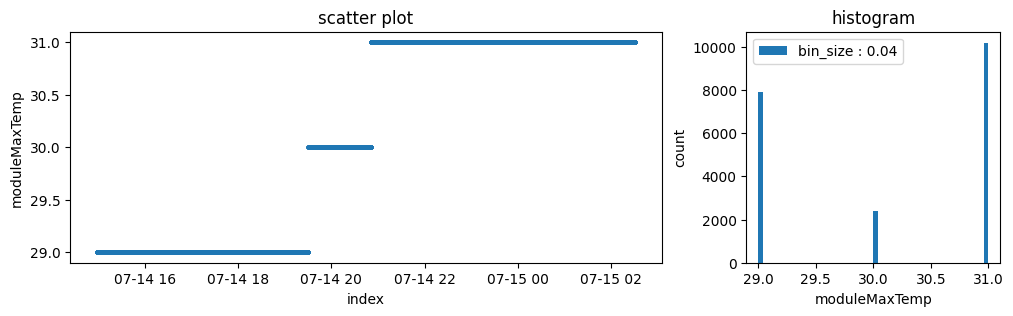

In [28]:
k.plot_feature(select_df,'moduleMaxTemp')

Name :  soh
Total Qty :  20493
Avg :  99.79999999999997
Min :  99.8
Max :  99.8
Range :  0.0
Std :  2.842240290499647e-14


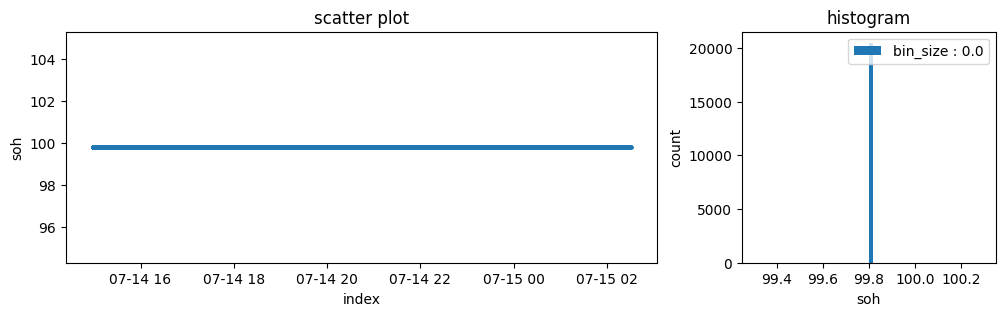

In [29]:
k.plot_feature(select_df,'soh')

Name :  odometer
Total Qty :  20493
Avg :  67568.0
Min :  67568
Max :  67568
Range :  0
Std :  0.0


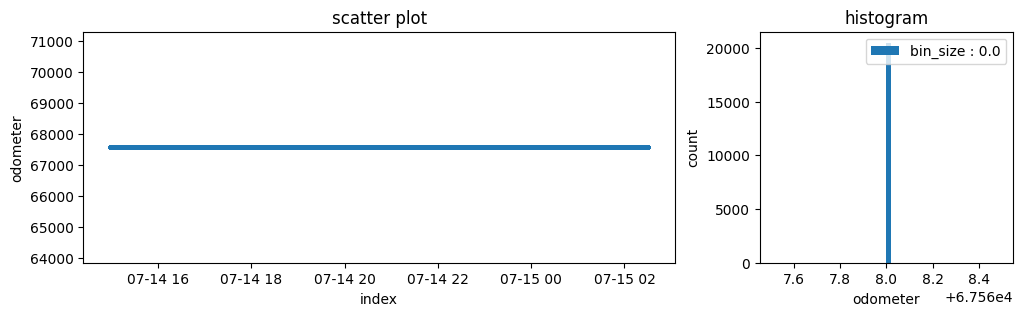

In [30]:
k.plot_feature(select_df,'odometer')

Name :  emobilitySpeed
Total Qty :  20493
Avg :  0.001366320206899917
Min :  0.0
Max :  4.0
Range :  4.0
Std :  0.0684316308759589


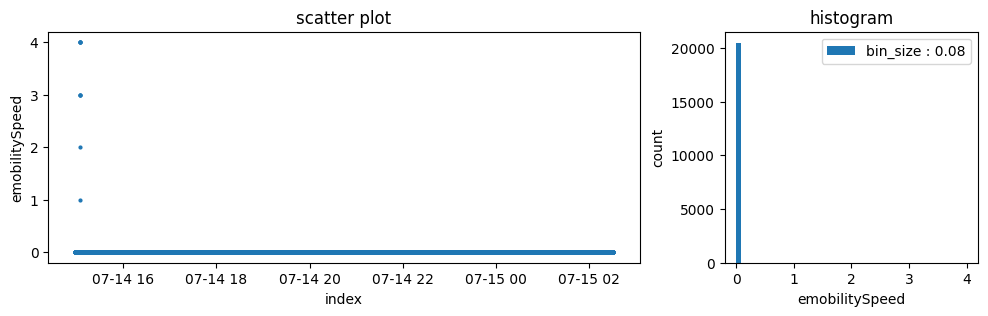

In [31]:
k.plot_feature(select_df,'emobilitySpeed')

R-squared :  0.992
Correlation :  0.996


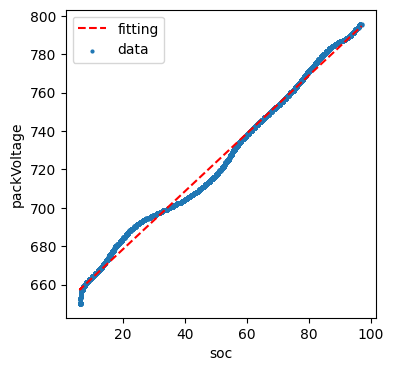

In [32]:
k.check_correlation(select_df, 'soc', 'packVoltage')

- 모델 학습을 위한 데이터를 만듭니다. 1800개는 (2초 간격으로 1시간에 해당합니다.)
- 전압, 전류, 모듈 온도를 학습 인자로 사용하였습니다.

In [34]:
# 입력 데이터 만들기

x_columns = ['packVoltage', 'packCurrent', 'moduleMaxTemp']

input_sample_1 = select_df[0:1800][x_columns].values   # 뒤쪽 한시간 데이터만 가져오기
input_sample_2 = select_df[10000:11800][x_columns].values
input_sample_3 = select_df[-1800:][x_columns].values

input_array_1 = input_sample_1.reshape(1, 1800, 3)
input_array_2 = input_sample_2.reshape(1, 1800, 3)
input_array_3 = input_sample_3.reshape(1, 1800, 3)

print("입력 shape:", input_array_1.shape)
print("입력 shape:", input_array_2.shape)
print("입력 shape:", input_array_3.shape)

입력 shape: (1, 1800, 3)
입력 shape: (1, 1800, 3)
입력 shape: (1, 1800, 3)


In [37]:
input_array_3

array([[[786.1,  -8.1,  31. ],
        [786.1,  -8.1,  31. ],
        [786.1,  -8.1,  31. ],
        ...,
        [795.9,  -8. ,  31. ],
        [795.9,  -8. ,  31. ],
        [795.4,  -3.8,  31. ]]])

- 입력 (전압, 전류, 온도)과 출력 (SOH 계산) 값을 정의하고 통합 Array를 구성합니다.

In [88]:
# 입력 어레이 배열 만들기

input_list = []
output_array = np.array([])

x_columns = ['packVoltage', 'packCurrent', 'moduleMaxTemp']
y_column = 'SOH_prediction'

for n in range(len(dataset_soh)):

    select_data = df[dataset_soh.loc[n, 'start_time'] : dataset_soh.loc[n, 'end_time']]
    sample = select_data[-1800:][x_columns].values   # 뒤쪽 한시간 데이터만 가져오기

    if len(sample) == 1800:   # 한시간 데이터가 있는 범위만 SOH 추가

        input_list.append(sample)

        output_soh = dataset_soh.iloc[n][y_column]
        output_array = np.append(output_array, output_soh)

    else : pass

input_array = np.stack(input_list, axis=0)

print("입력 shape:", input_array.shape)
print("출력 shape:", output_array.shape)

입력 shape: (813, 1800, 3)
출력 shape: (813,)


In [89]:
# 전체 SOH 구간 대비 입력 데이터 비율

len(output_array)/len(dataset_soh)

0.7304582210242587

In [90]:
# 입력 인자 확인

df.loc[:, x_columns]

,packVoltage,packCurrent,moduleMaxTemp
time,,,
2023-05-01 12:08:35,777.8,0.6,17.0
2023-05-01 12:08:37,777.8,0.6,17.0
2023-05-01 12:08:39,777.8,0.6,17.0
2023-05-01 12:08:41,777.8,0.7,17.0
2023-05-01 12:08:43,777.8,0.7,17.0
...,...,...,...
2025-07-15 09:06:44,744.3,-3.3,29.0
2025-07-15 09:06:46,744.3,-3.4,29.0
2025-07-15 09:06:48,744.3,-3.3,29.0


In [91]:
# 출력 인자 확인
 
dataset_soh[y_column]

0       102.850
1       103.417
2       102.810
3       102.986
4       102.952
         ...   
1108    102.898
1109    103.142
1110    102.878
1111    102.818
1112    102.234
Name: SOH_prediction, Length: 1113, dtype: float64

In [93]:
# 입력 정의 하기

X = input_array
y = output_array

In [94]:
# 입력 정규화

from sklearn.preprocessing import StandardScaler

# 3개 특성 (전압, 전류, 온도)에 대해 각 feature 정규화
X_reshaped = X.reshape(-1, len(x_columns))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

In [95]:
# 데이터 분리 (시계열, No shuffle)

n = len(X_scaled)

# 비율 설정
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1  # 또는 test = 나머지

# 인덱스 계산
train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)

# 데이터 분리 (X)
X_train = X_scaled[:train_end]
X_vali = X_scaled[train_end:val_end]
X_test = X_scaled[val_end:]

# 데이터 분리 (Y)
y_train = y[:train_end]
y_vali = y[train_end:val_end]
y_test = y[val_end:]

len(X_train), len(X_vali), len(X_test), len(y_train), len(y_vali), len(y_test)

(650, 81, 82, 650, 81, 82)

### 딥러닝 모델 만들기
- 배터리의 전압, 전류, 온도 특성을 학습하는 CNN과 시계열 패턴을 학습하는 LSTM모델을 융합하였습니다.
- 모델의 하이퍼파라미터는 최적화를 위해 휴리스틱한 방법을 방법을 적용하였습니다.

In [97]:
# Sequential() 모델 정의 하고 model로 저장
# input layer는 input_shape=() 옵션을 사용한다.

from tensorflow.keras.layers import Conv1D, BatchNormalization, LSTM, ReLU, MaxPooling1D, Bidirectional, Dense, Input


# 입력: (1800, ??)
model = Sequential([
    Input(shape=(1800, len(x_columns))),

    # Convolution Stage 1
    Conv1D(32, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Convolution Stage 2
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Convolution Stage 3
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Convolution Stage 4
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(pool_size=2),

    Dropout(0.1),  # 과적합 방지

    # LSTM: 시퀀스 학습
    Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1)),

    # 출력층
    Dense(64, activation='relu'),
    Dropout(0.1),
    
    Dense(1)  # SOH 회귀

])


In [ ]:
# 모델 파라미터 확인

model.summary()  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1800, 32)          320       
                                                                 
 batch_normalization_4 (Batc  (None, 1800, 32)         128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 1800, 32)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 1800, 64)          6208      
                                                                 
 batch_normalization_5 (Batc  (None, 1800, 64)         256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 1800, 64)         

In [99]:
# 모델 학습 최적화 선택

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(loss='mae', optimizer='adam', metrics='mae')

early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

In [100]:
# 앞쪽에서 정의된 모델 이름 : model
# Sequential 모델의 fit() 함수 사용

history = model.fit(X_train, y_train,
                    validation_data=(X_vali, y_vali),
                    epochs = 100,
                    batch_size = 16,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/100
41/41 [==============================] - 366s 9s/step - loss: 83.3569 - mae: 83.3569 - val_loss: 69.2495 - val_mae: 69.2495 - lr: 0.0010
Epoch 2/100
41/41 [==============================] - 372s 9s/step - loss: 30.1793 - mae: 30.1793 - val_loss: 7.7055 - val_mae: 7.7055 - lr: 0.0010
Epoch 3/100
41/41 [==============================] - 375s 9s/step - loss: 5.3970 - mae: 5.3970 - val_loss: 5.4025 - val_mae: 5.4025 - lr: 0.0010
Epoch 4/100
41/41 [==============================] - 381s 9s/step - loss: 5.1072 - mae: 5.1072 - val_loss: 4.1604 - val_mae: 4.1604 - lr: 0.0010
Epoch 5/100
41/41 [==============================] - 376s 9s/step - loss: 5.0057 - mae: 5.0057 - val_loss: 2.8286 - val_mae: 2.8286 - lr: 0.0010
Epoch 6/100
41/41 [==============================] - 374s 9s/step - loss: 4.6510 - mae: 4.6510 - val_loss: 1.1873 - val_mae: 1.1873 - lr: 0.0010
Epoch 7/100
41/41 [==============================] - 376s 9s/step - loss: 4.9459 - mae: 4.9459 - val_loss: 0.9976 - val_mae:

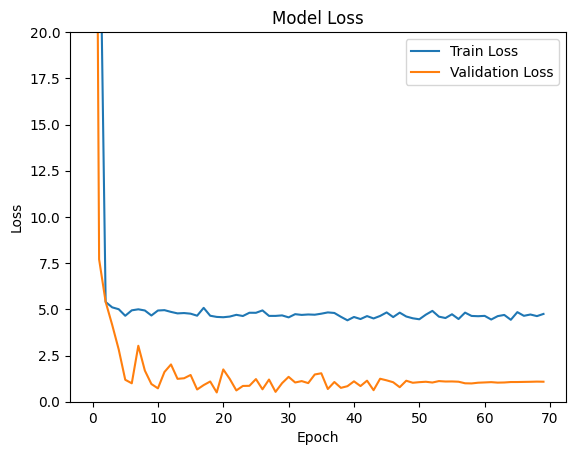

In [101]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,20)
plt.legend()
plt.show()